In [4]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.sparse as spar
from scipy import integrate
from scipy.sparse import csr_matrix
%matplotlib inline
import sys
from matplotlib import cm
from matplotlib import animation

In [5]:
N=19
Tf = 2.0
dt = 0.005
Nt = int(np.ceil(Tf/dt))
b=1
a=0
h = (b-a)/(N+1)

In [6]:
Nt*N

7600

In [7]:
def M(N):
    A = (np.diag([2/3 for i in range(N)],0)+np.diag([1/6 for i in range(N-1)],-1)+np.diag([1/6 for i in range(N-1)],1))
    return h*A

def A(N):
    B = (np.diag([2 for i in range(N)],0)+np.diag([-1 for i in range(N-1)],-1)+np.diag([-1 for i in range(N-1)],1))
    return 1/h*B

In [8]:
#Finite element projection
def Initial_pos(N,b,a,f):
    h = (b-a)/(N+1)
    def f_1(x,f,begin):
        return 1/h**2*f(x)*(x-begin)
    def f_2(x,f,end):
        return 1/h**2*f(x)*(end-x)
    pos = np.linspace(a,b,N+2)
    Init = np.zeros(N+2)
    for i in range(1,N+1):
        dx1 = np.linspace(pos[i-1],pos[i],1001)
        dx2 = np.linspace(pos[i],pos[i+1],1001)
        Init[i] = integrate.simpson(f_1(dx1,f,pos[i-1]),dx1)+integrate.simpson(f_2(dx2,f,pos[i+1]),dx2)
    return Init

In [9]:
#Various test functions
f = lambda x: np.sin(2*np.pi*x/(b-a))
f4 = lambda x: 100*np.cos(4*np.pi*x/(b-a))
f2 = lambda x: 0 #np.sin(2*np.pi*x/(b-a))/

In [10]:
def g(x):
    if 1/4<=x and 3/4>=x:
        return 1
    else:
        return 0
    
g = lambda x: (1/4<x)*(3/4>x)
g2 = lambda x: np.exp(-(x-1/2)**2/(2*(1/20)**2))#1/(np.sqrt(2*np.pi)*3)*
g3 = lambda x: (-4*abs(x-1/2)+1)*(1/4<x)*(3/4>x)#1/(np.sqrt(2*np.pi)*3)*

In [11]:
#Initialisation
u_0 = Initial_pos(N,b,a,f)[1:-1]
u_1 = u_0 +dt*Initial_pos(N,b,a,f4)[1:-1]

In [12]:
#Set epsilon value
epsilon = 1/2*dt

In [13]:
Zero = np.zeros([N,N])
Id = np.identity(N)
M_ = M(N)
A_ = A(N)
M_inv_A = np.linalg.inv(M_)@A_
M_inv = np.linalg.inv(M_)
C2 = []

In [14]:
#Create periodic matrix
L = []
L.append([Id]+[Zero for i in range(Nt-1)])
z_0 = [-Id,Id]+[Zero for i in range(Nt-2)]
L.append(z_0)
k=j=0
for j in range(Nt-4):
    k = Nt-j-5
    z_J = [Zero for i in range(j)]+[(epsilon/dt)**2*Id,-(4*(epsilon/dt)**2-2*(epsilon/dt))*Id,(6*(epsilon/dt)**2-6*(epsilon/dt)+1)*Id + dt**2*M_inv_A,-(4*(epsilon/dt)**2-6*(epsilon/dt)+2)*Id,(epsilon/dt-1)**2*Id]+[Zero for i in range(k)]
    L.append(z_J)


#L.append([(epsilon/dt-1)**2*Id + dt**2*M_inv_A]+[Zero for i in range(Nt-6)]+[(epsilon/dt)**2*Id,-(4*(epsilon/dt)**2-2*(epsilon/dt))*Id,(6*(epsilon/dt)**2-6*(epsilon/dt)+1)*Id,-(4*(epsilon/dt)**2-6*(epsilon/dt)+2)*Id])

L.append([Id]+[Zero for i in range(Nt-5)]+[Id,-4*Id,6*Id,-4*Id])
L.append([Id]+[Zero for i in range(Nt-4)]+[-Id,3*Id,-3*Id])

L = csr_matrix(np.block(L))

In [15]:
Per = []
Per.append([Zero for i in range(Nt)])
z_0 = [Zero for i in range(Nt)]
Per.append(z_0)
k=j=0
for j in range(2,Nt-2):
    k = Nt-1-j
    z_J = [Zero for i in range(j)]+[M_inv]+[Zero for i in range(k)]
    Per.append(z_J)
Per.append(z_0)
Per.append(z_0)
Per =csr_matrix(np.block(Per))

In [16]:
#Set RHS
F = np.zeros(N*(Nt))
F[0:N] = u_0 
F[N:2*N] = 10*dt*Initial_pos(N,b,a,g2)[1:-1]

In [17]:
#Set p value
p = 8

In [18]:
#Define nonlinear equation
def Fun(x):
    return L@x +dt**2*p/2*Per@(x**(p-1))-F

In [19]:
def Fun2(x):
    return L@x -dt**2*1/2*Per@(np.sin(x))-F

In [20]:
#y = np.load("Periodic_10000_iters_p_9_Dim_450.npy")

In [21]:
x_guess = spar.linalg.spsolve(L,F)

In [23]:
x = sp.optimize.newton_krylov(Fun,x_guess, f_tol=1e-10,iter=1000)
#np.save("Periodic_100000_iters_p_9_Dim_450",x)

In [24]:
u = csr_matrix(np.zeros([Nt,N]))

u = x.reshape([Nt,N])

In [25]:
u_guess = csr_matrix(np.zeros([Nt+2,N]))

u_guess = x_guess.reshape([Nt,N])

In [26]:
fig = plt.figure(figsize = (6,4), dpi=250)
ax = plt.axes()
f_stride = 2
ims = [None for i in range(int(Nt/f_stride)+4)]
#plt.plot(x_plot,rho_inf_vals,color='r')
for l in range(int(Nt/f_stride)):
    im, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(f_stride*l),:],[0]]),color='b',label='non linear sol')
    #im2, = ax.plot(np.linspace(a,b,N+2),true_sol(np.linspace(a,b,N+2),f_stride*l*dt),color='r',label='true sol',alpha=1)
   # im3, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(f_stride*l),:],[0]]),color='r',label='guess linear sol')
    title = ax.text(0.45,-1.5, "t={}".format('%s' % float(str('%s' % float('%.2g' % float(f_stride*l*dt)))[:4])))
    title2 = ax.text(0.25,-1.8, r"$u_0=\sin(2\pi x),\: u_0'=100\cos(4 \pi x)$")
    title3 = ax.text(0.35,1.5, r"$\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}+4u^7=0$",size=12)
    ims[l] = [im,title,title2,title3]
#plt.grid()
plt.plot(np.linspace(a,b,N+2),np.concatenate([[0],u[0,:],[0]]),alpha=0.2,linestyle='--',color='k')
im, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u[0,:],[0]]),color='b',label='non linear sol')
#im3, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[0,:],[0]]),color='r',label='guess linear sol')
ims[-4] = [im,title,title3,title2]
plt.plot(np.linspace(a,b,N+2),np.concatenate([[0],u[0,:],[0]]),alpha=0.2,linestyle='--',color='k')
im, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u[0,:],[0]]),color='b',label='non linear sol')
#im3, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[0,:],[0]]),color='r',label='guess linear sol')
ims[-3] = [im,title,title3,title2]
plt.plot(np.linspace(a,b,N+2),np.concatenate([[0],u[0,:],[0]]),alpha=0.2,linestyle='--',color='k')
im, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u[0,:],[0]]),color='b',label='non linear sol')
#im3, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[0,:],[0]]),color='r',label='guess linear sol')
ims[-2] = [im,title,title3,title2]
plt.plot(np.linspace(a,b,N+2),np.concatenate([[0],u[0,:],[0]]),alpha=0.2,linestyle='--',color='k')
im, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u[0,:],[0]]),color='b',label='non linear sol')
#im3, = ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[0,:],[0]]),color='r',label='guess linear sol')
ims[-1] = [im,title,title3,title2]
plt.rcParams["animation.html"]= 'html5'
plt.title(r"Periodic, Dim={}, $\epsilon/\tau=1/2$, $\tau$={}, $h$={}".format(Nt*N,dt,h,p))
plt.ylim([-2,2])
#ax.legend(handles=[im,im3],loc='upper right')
ani = animation.ArtistAnimation(fig,ims,interval = 100)
#plt.legend(loc='upper right')
plt.close()

In [27]:
ani

In [31]:
print("Computed_min, {}".format(np.linalg.norm(x)))

Computed_min, 56.72949270652655


In [32]:
print("Computed_min_guess, {}".format(np.linalg.norm(x_guess)))

Computed_min_guess, 66.83577178800942


Text(0.5, 0.98, "Periodic Solver: $\\frac{\\partial^2 u}{\\partial t^2}-\\frac{\\partial^2 u}{\\partial x^2}+4u^7=0$, $\\epsilon/\\tau$=0.5\n h=0.05,$\\tau=0.005$\nT=2.0,b-a=1\n$u_0=\\sin(2\\pi x),\\: u_0'=2\\cos(10\\pi x)$")

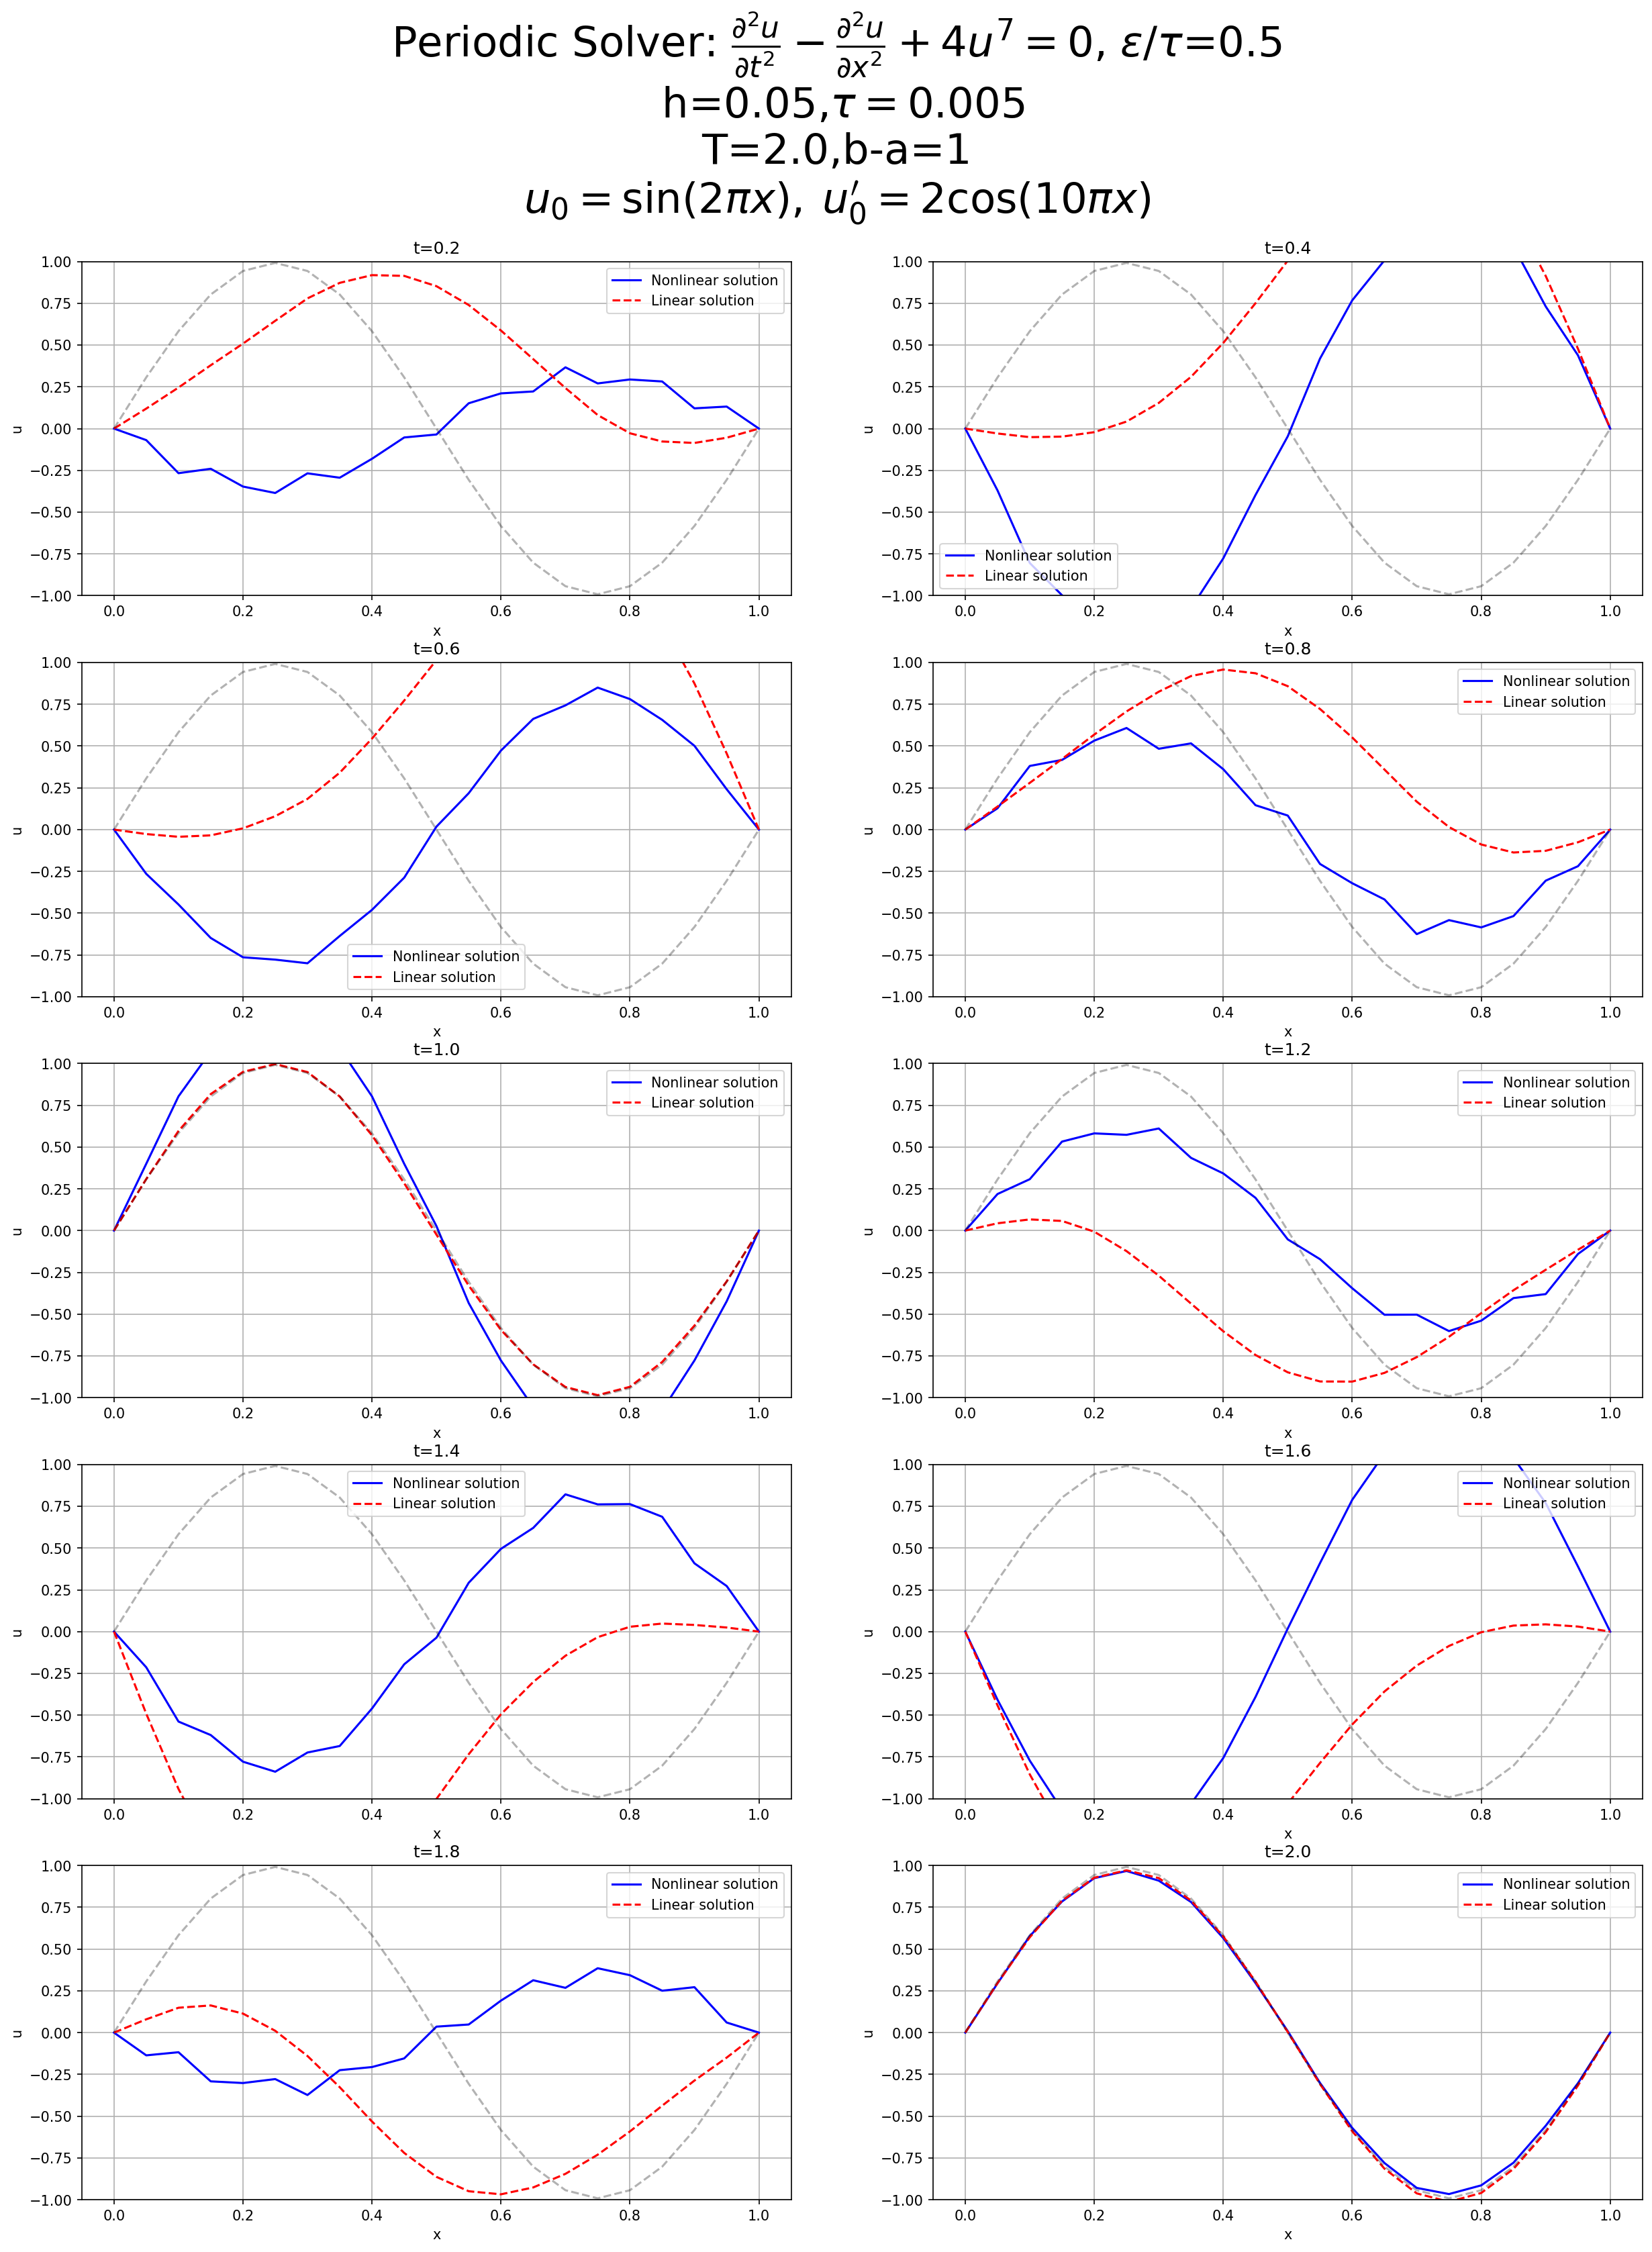

In [30]:
fig,axs = plt.subplots(5,2,figsize=(20,25),dpi=150)

stride = Nt/10

axs[0,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(stride*1),:],[0]]),color='b',label='Nonlinear solution',linestyle='-')
axs[0,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(stride*1),:],[0]]),color='r',label='Linear solution',alpha=1,linestyle='--')
axs[0,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(stride*2),:],[0]]),color='b',label='Nonlinear solution',linestyle='-')
axs[0,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(stride*2),:],[0]]),color='r',label='Linear solution',alpha=1,linestyle='--')
axs[1,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(stride*3),:],[0]]),color='b',label='Nonlinear solution',linestyle='-')
axs[1,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(stride*3),:],[0]]),color='r',label='Linear solution',alpha=1,linestyle='--')
axs[1,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(stride*4),:],[0]]),color='b',label='Nonlinear solution',linestyle='-')
axs[1,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(stride*4),:],[0]]),color='r',label='Linear solution',alpha=1,linestyle='--')
axs[2,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(stride*5),:],[0]]),color='b',label='Nonlinear solution',linestyle='-')
axs[2,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(stride*5),:],[0]]),color='r',label='Linear solution',alpha=1,linestyle='--')
axs[2,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(stride*6),:],[0]]),color='b',label='Nonlinear solution',linestyle='-')
axs[2,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(stride*6),:],[0]]),color='r',label='Linear solution',alpha=1,linestyle='--')
axs[3,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(stride*7),:],[0]]),color='b',label='Nonlinear solution',linestyle='-')
axs[3,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(stride*7),:],[0]]),color='r',label='Linear solution',alpha=1,linestyle='--')
axs[3,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(stride*8),:],[0]]),color='b',label='Nonlinear solution',linestyle='-')
axs[3,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(stride*8),:],[0]]),color='r',label='Linear solution',alpha=1,linestyle='--')
axs[4,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(stride*9),:],[0]]),color='b',label='Nonlinear solution',linestyle='-')
axs[4,0].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(stride*9),:],[0]]),color='r',label='Linear solution',alpha=1,linestyle='--')
axs[4,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u[int(stride*10)-1,:],[0]]),color='b',label='Nonlinear solution',linestyle='-')
axs[4,1].plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[int(stride*10)-1,:],[0]]),color='r',label='Linear solution',alpha=1,linestyle='--')

axs[0,0].set_title("t={}".format(1*stride/Nt*Tf))
axs[0,1].set_title("t={}".format(2*stride/Nt*Tf))
axs[1,0].set_title("t={}".format(3*stride/Nt*Tf))
axs[1,1].set_title("t={}".format(4*stride/Nt*Tf))
axs[2,0].set_title("t={}".format(5*stride/Nt*Tf))
axs[2,1].set_title("t={}".format(6*stride/Nt*Tf))
axs[3,0].set_title("t={}".format(7*stride/Nt*Tf))
axs[3,1].set_title("t={}".format(8*stride/Nt*Tf))
axs[4,0].set_title("t={}".format(9*stride/Nt*Tf))
axs[4,1].set_title("t={}".format(10*stride/Nt*Tf))


for ax in axs.flat:
    ax.set(xlabel='x',ylabel='u')
    ax.grid()
    ax.legend()
    ax.set_ylim([-1,1])
    ax.plot(np.linspace(a,b,N+2),np.concatenate([[0],u_guess[0,:],[0]]),alpha=0.3,linestyle='--',color='k')
    
fig.suptitle("Periodic Solver: " +r"$\frac{\partial^2 u}{\partial t^2}-\frac{\partial^2 u}{\partial x^2}+4u^7=0$,"+r" $\epsilon/\tau$"+"={}".format(epsilon/dt)+"\n"+r" h={},$\tau={}$".format(h,dt)+"\n"+"T={},b-a={}".format(Tf,b-a)+"\n"+r"$u_0=\sin(2\pi x),\: u_0'=2\cos(10\pi x)$",fontsize=30)